In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score
from sklearn.base import BaseEstimator, TransformerMixin

from typing import Union, List
from sklearn import set_config
set_config(transform_output="pandas")

In [22]:
df = pd.read_csv('../data/raw/train_data.csv')

In [23]:
target = df['Exited']
df.drop(labels=['Exited'], axis=1, inplace=True)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=42)

In [25]:
print(X_train.shape)
X_train.head()

(114863, 13)


,ID,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
91348,108635,15606267,Wilson,622,France,Female,35.0,7,98640.74,2,1.0,1.0,110457.99
2636,147941,15644891,Pirozzi,752,France,Female,32.0,2,0.00,1,1.0,0.0,159843.24
117007,88744,15702464,Watson,710,France,Male,31.0,4,0.00,3,0.0,0.0,160548.66
100279,125789,15701605,L?,704,Germany,Male,46.0,4,138912.17,1,0.0,1.0,141804.78
34835,135997,15757577,Hs?,675,Germany,Female,51.0,8,143390.51,1,1.0,0.0,168034.90


### Checking outliers

In [26]:
keep_cols = ['CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary']
X_train[keep_cols].head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
91348,622,France,Female,35.0,7,98640.74,2,1.0,1.0,110457.99
2636,752,France,Female,32.0,2,0.00,1,1.0,0.0,159843.24
117007,710,France,Male,31.0,4,0.00,3,0.0,0.0,160548.66
100279,704,Germany,Male,46.0,4,138912.17,1,0.0,1.0,141804.78
34835,675,Germany,Female,51.0,8,143390.51,1,1.0,0.0,168034.90


### IQR outliers method

In [27]:
def iqr_outliers_bound(feature:pd.Series, thereshold=1.5):

    q1 = feature.quantile(0.25)
    q3 = feature.quantile(0.75)

    IQR = q3 - q1

    lower_bound = q1 - thereshold * IQR
    upper_bound = q3 + thereshold * IQR
    
    return lower_bound, upper_bound

def remove_outliers(data:pd.DataFrame, target, columns:Union[str, List[str]]) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    ''' 
    Arguments:
    - data: the data from where the ouliers will be removed
    - columns: type list, array of the column names from data to calculate the outliers
    returns
        - a new DataFrame with the data with ouliers removed
        - a new DataFrame with only the ouliers
    '''
    if isinstance(columns, str):
        columns = [columns]
        
    data_copy = data.copy()
    target_copy = target.copy()
    #outliers = pd.DataFrame(columns=data.columns).astype(data.dtypes.to_dict()) #empty dataframe. Carefull Patty, an empty DF needs columns at their types.
    
    # Create an outlier mask
    outlier_mask = np.zeros(len(data), dtype=bool)
    
    for col in columns:
        lower_bound, upper_bound = iqr_outliers_bound(data[col], thereshold=1.5)
        #data_copy = data.query(f'{col} >= @lower_bound & {col} <= @upper_bound' )
        outlier_mask |= (data[col] < lower_bound) | (data[col] > upper_bound)       
        print(f'#outliers {col}={outlier_mask.sum()}')
    print(f'Total outliers={outlier_mask.sum()}')
    data_copy = data.loc[~outlier_mask]
    target_copy = target.loc[~outlier_mask]
    outliers = data.loc[outlier_mask]
    
    return data_copy, target_copy, outliers


#### Age and CreditScore ouliers

In [28]:
col = 'CreditScore'
lower_bound, upper_bound = iqr_outliers_bound(X_train[col])
X_train.query(f'{col} < @lower_bound | {col} > @upper_bound')

,ID,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
124275,99188,15660316,Stephenson,420,Germany,Female,34.0,1,143321.97,1,0.0,0.0,61936.10
109266,51518,15593969,Payne,405,France,Male,39.0,10,0.00,1,1.0,1.0,160810.85
141632,72388,15779947,Thomas,363,Spain,Female,28.0,7,146098.43,3,1.0,0.0,100615.14
132856,83197,15718893,Pirozzi,404,Spain,Male,54.0,8,125456.07,1,1.0,0.0,83715.66
74166,81620,15656300,Lucciano,411,France,Male,39.0,0,59697.17,2,1.0,1.0,53483.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67904,143268,15794413,Harris,416,France,Male,32.0,0,0.00,1,0.0,0.0,878.87
137488,104361,15582944,Becker,425,Spain,Female,28.0,3,0.00,2,1.0,0.0,140941.47
67843,114729,15597896,Ozoemena,365,Germany,Male,59.0,0,127760.07,1,1.0,0.0,81537.85
57492,143821,15718893,Pirozzi,404,France,Male,54.0,4,125456.07,1,1.0,0.0,83715.66


In [29]:
col = 'Age'
lower_bound, upper_bound = iqr_outliers_bound(X_train[col])
X_train.query(f'{col} < @lower_bound | {col} > @upper_bound')

,ID,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
24617,147990,15599081,Ku,697,Germany,Female,62.0,8,115062.61,1,1.0,0.0,23305.01
88066,114406,15700223,Milani,641,France,Male,60.0,1,0.00,2,1.0,1.0,131768.58
121853,11376,15573854,Shih,727,Germany,Male,62.0,8,119839.69,2,1.0,0.0,51016.02
53177,115774,15647570,Chung,682,France,Male,64.0,5,0.00,2,0.0,1.0,195123.94
16391,159017,15655082,Pape,607,France,Female,60.0,7,112070.86,1,1.0,0.0,173568.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70467,58693,15801934,Su,656,France,Male,66.0,8,0.00,2,1.0,1.0,47117.03
139182,86920,15575410,Manna,656,Germany,Male,58.0,1,116936.81,1,1.0,1.0,104272.04
113569,19606,15796838,Biryukov,648,France,Male,62.0,3,0.00,2,1.0,1.0,89935.73
13986,20182,15656484,Woods,682,France,Male,60.0,8,0.00,1,1.0,1.0,140745.91


In [30]:
X_train, y_train, outliers = remove_outliers(data=X_train, target=y_train, columns= ['CreditScore', 'Age'])
outliers.shape[0]

#outliers CreditScore=191
#outliers Age=4653
Total outliers=4653


4653

In [31]:
X_train.shape[0],y_train.shape[0]

(110210, 110210)

- Remove rows from y corresponding to the removed outliers

#### Balance and EstimatedSalary outliers

> Balance and EstimatedSalary don't have ouliers.  Even if the had, they should be anything they want

### Drop columns

def drop_columns(data:pd.DataFrame):
    cols_to_drop = ['ID','CustomerId', 'Surname']
    return data.drop(columns=cols_to_drop, axis=1)

transf_dropcols = FunctionTransformer(drop_columns)

In [47]:
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        self._remaining_columns = [col for col in X.columns if col not in self.columns_to_drop]
        return X.drop(columns=self.columns_to_drop, errors="ignore")

    def get_feature_names_out(self, input_features=None):
        ''' 
        Parameters:
        - input_features: In case the the transformer is in a pipeline, these are the features it receives from a previous transformer.
        '''
        print(f'get_feature_names_out(input_features={input_features})')
        return self._remaining_columns


In [48]:
cols_to_drop = ['ID','CustomerId', 'Surname']
transf_dropcols = DropColumns(cols_to_drop)

In [49]:
transf_dropcols.fit(X=X_train, y=y_train)
transf_dropcols.transform(X=X_train)

get_feature_names_out(input_features=None)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
91348,622,France,Female,35.0,7,98640.74,2,1.0,1.0,110457.99
2636,752,France,Female,32.0,2,0.00,1,1.0,0.0,159843.24
117007,710,France,Male,31.0,4,0.00,3,0.0,0.0,160548.66
100279,704,Germany,Male,46.0,4,138912.17,1,0.0,1.0,141804.78
34835,675,Germany,Female,51.0,8,143390.51,1,1.0,0.0,168034.90
...,...,...,...,...,...,...,...,...,...,...
110268,850,France,Male,36.0,1,0.00,2,1.0,1.0,108747.12
119879,748,France,Male,28.0,4,167268.98,1,1.0,0.0,169423.72
103694,576,France,Male,37.0,4,0.00,2,1.0,1.0,55868.97
131932,479,Germany,Female,43.0,2,90218.11,1,1.0,1.0,102908.91


### Encoding and Scaling

In [50]:
encode_cols = ['Geography', 'Gender'] 
normalization_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

In [51]:
transf_encoding = ColumnTransformer(transformers=[('OneHotEncoder', OneHotEncoder(drop='first', sparse_output=False), encode_cols),
                                                  ('Normalization', StandardScaler(), normalization_cols )], remainder='passthrough'
                                    ,force_int_remainder_cols=False
                                    ,verbose_feature_names_out=False)
transf_encoding

ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                  transformers=[('OneHotEncoder',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['Geography', 'Gender']),
                                ('Normalization', StandardScaler(),
                                 ['CreditScore', 'Age', 'Tenure', 'Balance',
                                  'EstimatedSalary'])],
                  verbose_feature_names_out=False)

In [52]:
main_pipeline = Pipeline(steps=[('DropColumns', transf_dropcols),
                                ('Preprocess', transf_encoding),
                                #('Regression', LogisticRegression())
                                ])
main_pipeline

Pipeline(steps=[('DropColumns',
                 DropColumns(columns_to_drop=['ID', 'CustomerId', 'Surname'])),
                ('Preprocess',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('OneHotEncoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Geography', 'Gender']),
                                                 ('Normalization',
                                                  StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'EstimatedSalary'])],
                                   verbose_feature_names_out=False))])

In [103]:
def display_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    fig, ax = plt.subplots(figsize=(4,4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=classes)

    disp.plot(ax=ax)
    plt.show()

def display_scores(y_true, y_pred, classes):
    display_confusion_matrix(y_true, y_pred, classes)    
    print('precision=',precision_score(y_true=y_true, y_pred=y_pred))
    print('recall=',recall_score(y_true=y_true, y_pred=y_pred))
    print('f1_score=',f1_score(y_true=y_true, y_pred=y_pred))

In [53]:
X_train_transformed = main_pipeline.fit_transform(X=X_train, y=y_train)

get_feature_names_out(input_features=None)
get_feature_names_out(input_features=None)


## Predictions with default values

### Logistic Regression

In [54]:
logRegr = LogisticRegression()
logRegr.fit(X_train_transformed, y_train)

LogisticRegression()

In [89]:
predictions = logRegr.predict(X=X_train_transformed)
predictions

array([0, 0, 0, ..., 0, 1, 0])

#### Score X_train

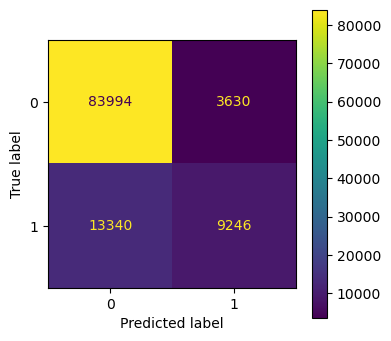

precision= 0.7180801491146319
recall= 0.4093686354378819
f1_score= 0.5214595905476285


In [104]:
display_scores(y_true=y_train, y_pred=predictions, classes=logRegr.classes_)

In [105]:
X_test_transformed = main_pipeline.transform(X=X_test)
X_test_transformed.head()

get_feature_names_out(input_features=None)


,Geography_Germany,Geography_Spain,Gender_Male,CreditScore,Age,Tenure,Balance,EstimatedSalary,NumOfProducts,HasCrCard,IsActiveMember
19336,0.0,0.0,1.0,0.264591,-0.831790,1.059839,-0.882965,0.254889,2,1.0,0.0
17029,0.0,1.0,1.0,1.623313,0.254757,1.416024,-0.882965,0.992156,2,1.0,1.0
110768,1.0,0.0,1.0,1.774282,0.526393,-1.789642,1.490528,-2.124487,1,1.0,1.0
3427,1.0,0.0,0.0,-0.930582,-1.646700,-0.364902,1.337680,1.725166,1,1.0,0.0
30495,0.0,0.0,1.0,-1.773493,2.971124,0.703654,1.170776,0.140810,1,1.0,0.0


#### Score X_test

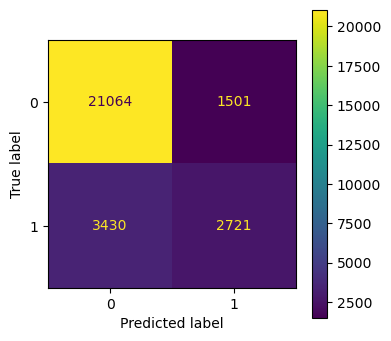

precision= 0.6444812884888679
recall= 0.44236709478133635
f1_score= 0.5246312542176805


In [106]:
predictions = logRegr.predict(X_test_transformed)
display_scores(y_test, predictions, logRegr.classes_)

#### RandomForestClassifier

In [63]:
from sklearn.ensemble import RandomForestClassifier

In [111]:
random_forest = RandomForestClassifier(n_estimators=50, min_samples_leaf=100, random_state=42)
random_forest.fit(X_train_transformed, y_train)

RandomForestClassifier(min_samples_leaf=100, n_estimators=50, random_state=42)

#### Scores in X_train

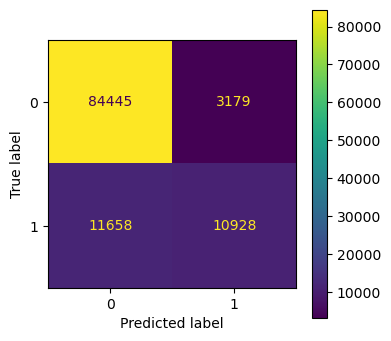

precision= 0.7746508825405827
recall= 0.4838395466218011
f1_score= 0.5956449459024882


In [112]:
predictions = random_forest.predict(X=X_train_transformed)
display_scores(y_train, predictions, random_forest.classes_)

Scores in X_test

In [113]:
predictions = random_forest.predict(X=X_test_transformed)
print(precision_score(y_true=y_test, y_pred=predictions))
print(recall_score(y_true=y_test, y_pred=predictions))
print(f1_score(y_true=y_test, y_pred=predictions))

0.7646013204672423
0.48951390017883273
0.5968876994746753


from pandas.plotting import scatter_matrix
attribs = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
scatter_matrix(X_train_transformed[attribs], figsize=(12,8))
plt.show()

In [114]:
from itertools import chain
# Use itertools.chain to merge the lists in an efficient manner
labels = list(chain(encode_cols, normalization_cols))

In [115]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(interaction_only=True)

poly_features.fit(X_train_transformed)


PolynomialFeatures(interaction_only=True)

In [116]:
main_pipeline.get_feature_names_out()

get_feature_names_out(input_features=None)


array(['Geography_Germany', 'Geography_Spain', 'Gender_Male',
       'CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember'], dtype=object)

In [117]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [118]:
knclassif = KNeighborsClassifier(n_neighbors=10)

knclassif.fit(X_train_transformed, y=y_train)

KNeighborsClassifier(n_neighbors=10)

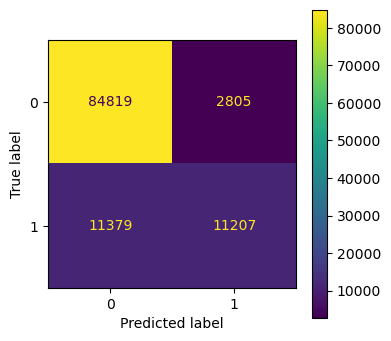

precision= 0.7998144447616329
recall= 0.49619233153280795
f1_score= 0.6124378381332313


In [119]:
predictions = knclassif.predict(X_train_transformed)
display_scores(y_train, predictions, knclassif.classes_)

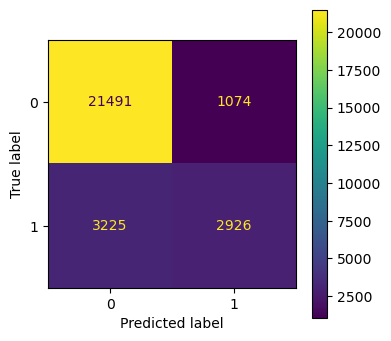

precision= 0.7315
recall= 0.4756950089416355
f1_score= 0.5764949266082159


In [121]:
predictions = knclassif.predict(X_test_transformed)
display_scores(y_true=y_test, y_pred=predictions, classes=knclassif.classes_)

In [ ]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [5, 10, 50]
}


In [125]:
from sklearn.metrics import f1_score, make_scorer

In [128]:
scorer = make_scorer(f1_score)

In [ ]:

rf_searchgrid = GridSearchCV(random_forest, rf_param_grid, scoring=scorer, cv=5, n_jobs=-1)


In [130]:
rf_searchgrid.fit(X_train_transformed, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(min_samples_leaf=100,
                                              n_estimators=50,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [5, 10, 50],
                         'n_estimators': [50, 100, 200]},
             scoring=make_scorer(f1_score, response_method='predict'))

In [131]:
rf_searchgrid.best_estimator_

RandomForestClassifier(min_samples_leaf=100, min_samples_split=5,
                       n_estimators=50, random_state=42)

In [132]:
rf_searchgrid.best_score_

np.float64(0.58932685921836)

In [133]:
predictions = rf_searchgrid.best_estimator_.predict(X_test_transformed)


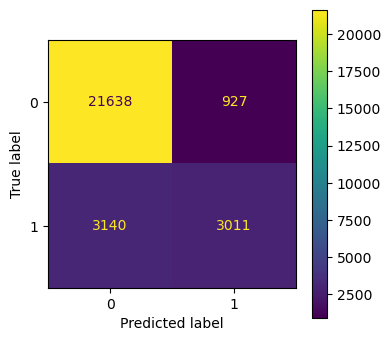

precision= 0.7646013204672423
recall= 0.48951390017883273
f1_score= 0.5968876994746753


In [134]:
display_scores(y_test, predictions, rf_searchgrid.best_estimator_.classes_)

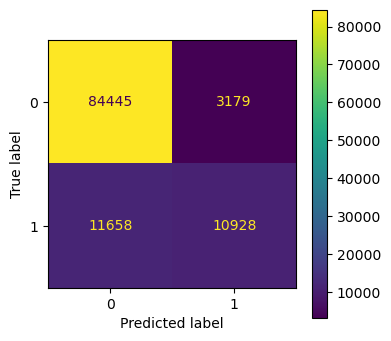

precision= 0.7746508825405827
recall= 0.4838395466218011
f1_score= 0.5956449459024882


In [143]:
best_randomforest = RandomForestClassifier(min_samples_leaf=100, min_samples_split=5,
                       n_estimators=50, random_state=42)
best_randomforest.fit(X_train_transformed, y_train)
preds = best_randomforest.predict(X_train_transformed)
display_scores(y_train, preds, best_randomforest.classes_)

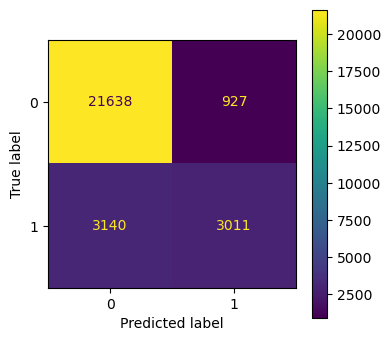

precision= 0.7646013204672423
recall= 0.48951390017883273
f1_score= 0.5968876994746753


In [144]:
preds = best_randomforest.predict(X_test_transformed)
display_scores(y_test, preds, best_randomforest.classes_)

#### KNeighbors

In [155]:
knn_param_grid = {
    'n_neighbors': [5, 10, 20],
    'weights': ['uniform', 'distance'],
}
knn_searchgrid = GridSearchCV(knclassif, knn_param_grid, scoring='accuracy', cv=5, n_jobs=-1)

In [156]:
knn_searchgrid.fit(X_train_transformed, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=10), n_jobs=-1,
             param_grid={'n_neighbors': [5, 10, 20],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [157]:
knn_searchgrid.best_estimator_

KNeighborsClassifier(n_neighbors=20, weights='distance')

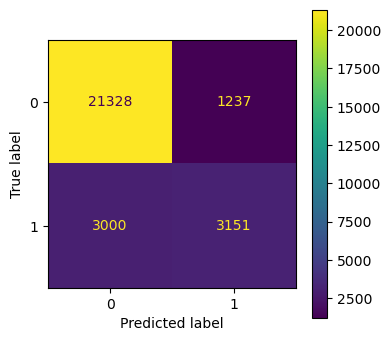

precision= 0.718094804010939
recall= 0.5122744269224516
f1_score= 0.597969446816586


In [158]:
predictions = knn_searchgrid.best_estimator_.predict(X_test_transformed)
display_scores(y_test, predictions, rf_searchgrid.best_estimator_.classes_)


In [139]:
test_data = pd.read_csv('./../data/raw/test_data.csv')
test_data.head()

,ID,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,67897,15585246,Bancks,585,France,Female,53.0,2,0.00,2,1.0,1.0,91830.75
1,163075,15604551,Robb,606,France,Male,24.0,2,0.00,1,0.0,1.0,90876.95
2,134760,15729040,Ugochukwu,633,Germany,Male,44.0,1,118907.60,1,1.0,0.0,47777.15
3,68707,15792329,Hs?,602,Germany,Male,40.0,2,149961.99,2,1.0,1.0,82696.84
4,3428,15617166,Genovesi,645,France,Male,31.0,4,132351.29,1,1.0,0.0,151887.16


In [140]:
testdata_transformed = main_pipeline.transform(test_data)


get_feature_names_out(input_features=None)


In [141]:
testdata_transformed


,Geography_Germany,Geography_Spain,Gender_Male,CreditScore,Age,Tenure,Balance,EstimatedSalary,NumOfProducts,HasCrCard,IsActiveMember
0,0.0,0.0,0.0,-0.905420,2.156213,-1.077272,-0.882965,-0.414554,2,1.0,1.0
1,0.0,0.0,1.0,-0.641224,-1.782519,-1.077272,-0.882965,-0.433553,1,0.0,1.0
2,1.0,0.0,1.0,-0.301544,0.933848,-1.433457,1.010537,-1.292030,1,1.0,0.0
3,1.0,0.0,1.0,-0.691547,0.390575,-1.077272,1.505052,-0.596487,2,1.0,1.0
4,0.0,0.0,1.0,-0.150574,-0.831790,-0.364902,1.224616,0.781671,1,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
21450,0.0,0.0,1.0,0.352656,-0.288517,-0.364902,-0.882965,1.243484,2,1.0,1.0
21451,0.0,1.0,0.0,-0.112832,1.341303,-0.721087,-0.882965,0.877150,1,1.0,0.0
21452,0.0,0.0,0.0,-0.628643,-0.695972,-0.721087,-0.882965,1.214142,2,1.0,1.0
21453,0.0,0.0,0.0,0.604271,2.563669,-1.789642,-0.882965,0.972728,1,1.0,0.0


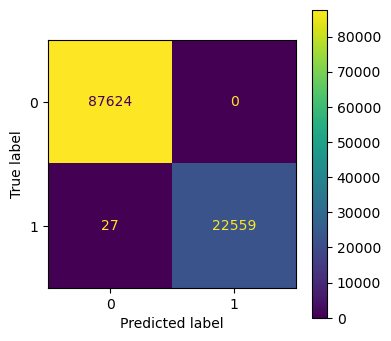

precision= 1.0
recall= 0.9988045692021607
f1_score= 0.9994019271237125


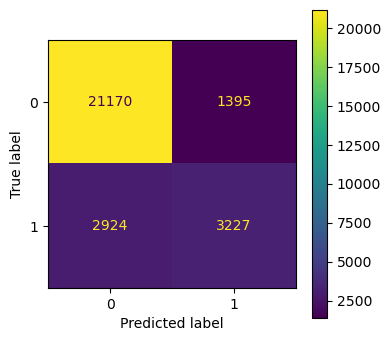

precision= 0.6981826049329295
recall= 0.5246301414404162
f1_score= 0.599090318388564


In [ ]:
knn_best = knn_searchgrid.best_estimator_
knn_best.fit(X_train_transformed, y_train)
preds = knn_best.predict(X_train_transformed)
display_scores(y_train, preds, knn_best.classes_)
preds = knn_best.predict(X_test_transformed)
display_scores(y_test, preds, knn_best.classes_)

In [149]:
kaggle_data_transformed = main_pipeline.transform(test_data)
kaggle_data_transformed.head()
kaggle_preds = random_forest.predict(kaggle_data_transformed)

df_result = pd.DataFrame({
    "ID": test_data['ID'],
    "Exited": kaggle_preds
    }
)
df_result

get_feature_names_out(input_features=None)


,ID,Exited
0,67897,0
1,163075,0
2,134760,1
3,68707,0
4,3428,0
...,...,...
21450,24790,0
21451,152608,1
21452,28134,0
21453,123871,1


In [151]:
df_result.set_index("ID", inplace=True)
df_result

,Exited
ID,
67897,0
163075,0
134760,1
68707,0
3428,0
...,...
24790,0
152608,1
28134,0


In [154]:
df_result.to_csv("./../data/submissions/submission-1.csv")